# Week 8: Basic Neural Networks

by Shivansh Rustagi, Santa Cruz Artificial Intelligence
derived from [this blog post](https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb)

Today, we're going to be creating and training a deep neural network. Once it is finished, we'll make some predictons.

First: let's review the steps needed to create a Neural Network:



1.   Prepare Data
2.   Initialize Neural Network Layers
3.   Activation functions (used to normalize outputs of neurons for next layer)
4.   Forward Propagation (used for predictions)
5.   Loss function (ensures we are moving in the right direction)
6.   Backward Propagation (learning and training)
7.   Updating parameters (optimize gradients)



# 1. Prepare Dataset:

In [0]:
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, load_iris

# secure the bag
iris = load_iris()

# since our neural network only has an input dimension of two, instead of using
# all four features in the dataset, we will only use petal length and width.
# this is why we have d[:2] in the code below

# furthermore, since our network uses the Binary Cross Entropy loss function
# we can only use two classes.
# iris flowers has 50 samples of each of the three classes, so I have simply
# chopped off the 50 which belong to the last class
# this is why the dataset is limited to the first 100 data using data[:100]
X = [d[:2] for d in iris.data[:100]]
y = iris.target[:100]

# generate a bunch of random linearly separable data for training
# this is good because you get as much annotated data as you want
# but also it literally doesn't mean anything, it's just a toy set.
# to use toy dataset, uncomment this line and change the number of  
# epochs to 1000

# X, y = make_moons(n_samples = 10000, noise=0.2, random_state=100)

# generate our training and testing labels and data!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# 2. Initialize Neural Network Layers

In [0]:
# this creates the architecture for our neural network. notice how the 
# dimension of inputs for layer `n` is equal to the dimensions of the outputs of
# layer `n-1`. the final layer has only one output, which is our prediction
network_config = [
  { 'input_dim': 2, 'output_dim': 25, 'activation': 'relu' },
  { 'input_dim': 25, 'output_dim': 50, 'activation': 'relu' },
  { 'input_dim': 50, 'output_dim': 50, 'activation': 'relu' },
  { 'input_dim': 50, 'output_dim': 25, 'activation': 'relu' },
  { 'input_dim': 25, 'output_dim': 1, 'activation': 'sigmoid' }
]

In [0]:
def init_layers(config, seed=69):
  np.random.seed(seed)
  network_num_layers = len(config)
  network_params = {}

  # enumerate is a python function which takes a dictionary and returns a
  # collated representation of the keys:
  # eg: {'a': 23, 'b': 42} -> [(0, 'a'), (1, 'b')]
  # this makes it easier to iterate over a dictionary, which otherwise does not
  # have any order
  for idx, layer in enumerate(config):
    # number the layers, starting at 1
    # YOUR CODE HERE
    layer_id = idx + 1
    layer_in = layer['input_dim']
    layer_out = layer['output_dim']

    # the np.random.randn function creates an array prepopulated with values
    # sampled from a normal distribution (standard deviation 1, mean 0)
    # the size of the array is determined by the arguments passed
    
    # the two lines of code below are creating randomly initialized weights
    # and biases for each layer of our network.
    network_params['W' + str(layer_id)] = np.random.randn(layer_out, layer_in) * 0.1
    network_params['b' + str(layer_id)] = np.random.randn(layer_out, 1) * 0.1
    
  return network_params

# 3. Activation Functions

In [0]:
# sigmoid function: often used as the last activation function in a neural 
# network, becase it maps numbers to a value between 0 and 1 
def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

# relu function: negative numbers are mapped to zero, otherwise the value remains the same
def relu(Z):
  # YOUR CODE HERE
  return np.maximum(0, Z)

# sigmoid derviative, which we will use during the backpropagation step
def sigmoid_derivative(dA, Z):
  return dA * sigmoid(Z) * (1 - sigmoid(Z))

# relu derviative, which we will use during the backpropagation step
def relu_derivative(dA, Z):
  dZ = np.array(dA, copy=True)
  dZ[Z <= 0] = 0
  return dZ

# 4. Forward Propagation

In [0]:
# execute the forward propagation step for one layer
# this is a helper function for the `full_forward_prop function`
def single_layer_forward_prop(A_prev, W, b, activation='relu'):
  # matrix multiply the weights with the old activation signal, and add bias
  # YOUR CODE HERE
  Z = np.dot(W, A_prev) + b
  # take this new intermediate result and calculate its activation signal
  A = relu(Z) if activation=='relu' else sigmoid(Z)
  return A, Z

# complete forward propagation step, used to run inferences
def full_forward_prop(X, params, config):
  # this is temporary "memory"/"cache" dictionary, which will store, among other
  # things, the temporary activation signals and matrices we need to carry out
  # backpropagation
  # YOUR CODE HERE
  temp = {}
  # the activation signal for the first layer is simply the input
  A = X

  # iterate over the layers to carry out forward propagation
  for idx, layer in enumerate(config):
    layer_id = idx + 1
    # get the activation signal from the previous layer
    A_prev = A

    # YOUR CODE HERE
    # get activation function, weights, and bias for the current layer
    activation = layer['activation']
    W = params['W' + str(layer_id)]
    b = params['b' + str(layer_id)]

    # carry out forward propagation for one layer
    # YOUR CODE HERE
    A, Z = single_layer_forward_prop(A_prev, W, b, activation)

    # store the activation signal and intermediate matrix in memory
    temp['A' + str(idx)] = A_prev
    temp['Z' + str(layer_id)] = Z

  return A, temp


# 5. Loss Function

In [0]:
# simply a python conversion of the Binary Cross Entropy Loss function
# we are using this loss function because it is ideal for choosing between
# two classes
def cost_fn(y_hat, y):
  # YOUR CODE HERE
  m = y_hat.shape[1]
  cost = -1 / m * (np.dot(y, np.log(y_hat).T) + np.dot(1 - y, np.log(1 - y_hat).T))
  # the np.squeeze function gets rid of extra dimensions of an array
  # eg: [[[[[1, 2, 3]], [[4, 5, 6]]]]] --> [[1, 2, 3], [4, 5, 6]]
  return np.squeeze(cost)

# a utility function which takes probabilities and changes them into classes
def prob_to_class(p):
  p_ = np.copy(p)
  p_[p_ > 0.5] = 1
  p_[p_ <= 0.5] = 0
  return p_

# calculate the accuracy
def accuracy_fn(y_hat, y):
    y_hat_ = prob_to_class(y_hat)
    # (y_hat_ == y) returns a matrix of boolean values, comparing each entry
    # in both matrices
    # once this is done, .all returns the `logical and` across axis 0, and 
    # computes the mean to give us our value for accuracy
    return (y_hat_ == y).all(axis = 0).mean()

# 6. Backpropagation

In [0]:
# backpropagation step for a single layer
def single_layer_back_prop(dA, W, b, Z, A_prev, activation="relu"):
  # get number of data points
  m = A_prev.shape[1]
  
  # math -> python
  dZ = relu_derivative(dA, Z) if activation == 'relu' else sigmoid_derivative(dA, Z)
  dW = np.dot(dZ, A_prev.T) / m
  db = np.sum(dZ, axis=1, keepdims=True) / m
  dA_prev = np.dot(W.T, dZ)

  return dW, db, dA_prev

def full_back_prop(y_hat, y, temp, params, config):
  # YOUR CODE HERE
  # dictionary we will use to calculate gradients
  gradients = {}
  m = y.shape[1]
  # ensure prediction and truth value vectors have same shape
  y = y.reshape(y_hat.shape)

  # differential of loss with respect to prediction
  dA_prev = -(np.divide(y, y_hat) - np.divide(1 - y, 1 - y_hat))

  # as implied in the algorithm name, we want to work backward and use what we 
  # have learned to compute the derivatives of the cost function with respect to
  # the weights 
  for idx, layer in reversed(list(enumerate(config))):
    layer_id = idx + 1
    activation = layer['activation']

    dA = dA_prev

    # recover the parameters for a given layer
    # YOUR CODE HERE
    A_prev = temp["A" + str(idx)]
    Z = temp["Z" + str(layer_id)]
    W = params["W" + str(layer_id)]
    b = params["b" + str(layer_id)]

    # carry out a single step of backpropagation on this layer
    # YOUR CODE HERE
    dW, db, dA_prev = single_layer_back_prop(dA, W, b, Z, A_prev, activation)

    # add the gradients we have calculated to be used later
    # YOUR CODE HERE
    gradients["dW" + str(layer_id)] = dW
    gradients["db" + str(layer_id)] = db
  
  return gradients



# 7. Update Parameters

In [0]:
# the actual learning part: using the gradients we have calculated to update the
# weights and biases
def update_params(params, config, gradients, learning_rate):
  # this time, we want to start the enumeration at 1 because we are moving up
  # the layers
  for idx, layer in enumerate(config, 1):
    # the learning rate is a hyperparameter which controls how fast or slowly
    # the parameters are updated (as you can see below, it directly scales by
    # how much the gradient is subtracted)
    # a super low learning rate could lead to the network never "converging"
    # and reaching an optimal solution, but a learning rate which is too high
    # could lead to DIVERGENCE, which is also very bad
    
    # YOUR CODE HERE
    params["W" + str(idx)] -= learning_rate * gradients['dW' + str(idx)]
    params["b" + str(idx)] -= learning_rate * gradients['db' + str(idx)]

  return params

# Finally... the training step!

In [0]:
def train(X, y, config, epochs, learning_rate):
  # create the network
  params = init_layers(config)
  # collect the cost and accuracy throughout training so that we can plot it if 
  # we want
  cost_history = []
  accuracy_history = []

  # an epoch is a hyperparameter which siginifies the number of complete passes
  # over the training dataset
  for i in range(epochs):
    # put together everything we wrote up there!
    y_hat, mem = full_forward_prop(X, params, config)
    
    # store accuracy and cost for later
    cost_history.append(cost_fn(y_hat, y))
    accuracy_history.append(accuracy_fn(y_hat, y))

    # YOUR CODE HERE
    gradients = full_back_prop(y_hat, y, mem, params, config)
    params = update_params(params, config, gradients, learning_rate)

  # we return the parameters here: aka, the newly trained weights and biases
  # for each layer of the network. We can use this set of optimized parameters
  # to run inference on new data, which is done below!
  return params, cost_history, accuracy_history 


# Testing

In [0]:
# train this bad boy!
params, _, accuracy_history = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), network_config, epochs=350, learning_rate=0.001)

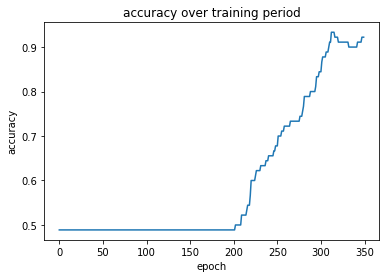

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# quickly just plot accuracy over training
plt.plot(accuracy_history)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('accuracy over training period')
plt.show()

In [12]:
# run inferences on test data!
# remember notation: y_hat is the predicted values, and we predict these values
# by sending our test data through the network via the FORWARD PROPAGATION step.
y_test_hat, _ = full_forward_prop(np.transpose(X_test), params, network_config)

# calculate and print final test accuracy
test_accuracy = accuracy_fn(y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f}".format(test_accuracy))

Test set accuracy: 1.00
